In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# INTRODUCTION
Le projet de machine learning présenté ici se concentre sur l'utilisation du jeu de données "Rain in Australia" pour prédire la variable "Rain Tomorrow". L'objectif principal est d'appliquer des techniques d'apprentissage automatique afin de développer un modèle prédictif capable de déterminer s'il va pleuvoir demain en fonction des variables météorologiques disponibles.

Dans ce projet, nous allons suivre les étapes typiques d'un projet de machine learning, à savoir :
- l'exploration des données,
- le prétraitement des données,
- la construction du modèle, l'évaluation du modèle
- et l'optimisation des performances.

## A.1. Chargement des données

In [51]:
dataset = pd.read_csv("weatherAUS.csv")
dataset.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


## A.2. Exploration préliminaire
Objectif : identifier les prétraitements éventuels nécessaires avant de construire notre modèle prédictif.

In [52]:
dataset.shape

(145460, 23)

In [53]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

En utilisant la méthode .info(), nous avons pu constater la présence de valeurs nulles dans certaines colonnes.
Cependant, pour obtenir une compréhension plus détaillée de l'étendue de ces valeurs manquantes, nous allons maintenant calculer le pourcentage de valeurs nulles pour chaque colonne.
Cela nous permettra d'identifier les colonnes qui contiennent un grand nombre de valeurs manquantes et de prendre des décisions éclairées sur la façon de traiter ces données manquantes.


In [54]:
total = dataset.isnull().sum().sort_values(ascending=False)
percent = (dataset.isnull().sum() / len(dataset) * 100).sort_values(ascending=False)
missing_data = pd.concat([total,percent],axis=1,keys=['Total','Percent'])
missing_data

,Total,Percent
Sunshine,69835,48.009762
Evaporation,62790,43.166506
Cloud3pm,59358,40.807095
Cloud9am,55888,38.421559
Pressure9am,15065,10.356799
Pressure3pm,15028,10.331363
WindDir9am,10566,7.263853
WindGustDir,10326,7.098859
WindGustSpeed,10263,7.055548
Humidity3pm,4507,3.098446


Pour obtenir une meilleure visualisation des valeurs nulles dans notre jeu de données, nous avons segmenté les variables en deux catégories : les variables de type "object" et les variables de type "float". En procédant ainsi, nous pouvons créer un diagramme en barres qui illustre le pourcentage de valeurs manquantes pour chaque catégorie.

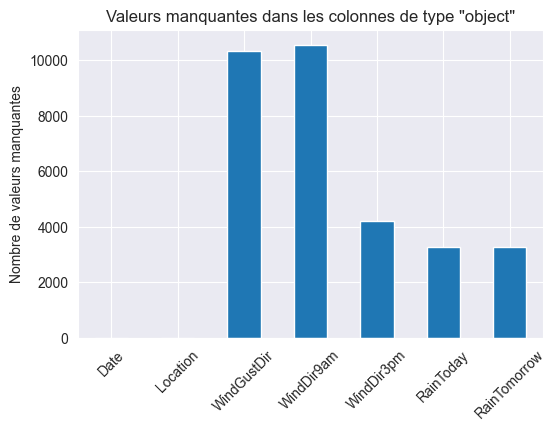

In [55]:
object_features = [column_name for column_name in dataset.columns if dataset[column_name].dtype == 'O']
missing_values = dataset[object_features].isnull().sum()
plt.figure(figsize=(6, 4))
missing_values.plot(kind='bar')
plt.ylabel('Nombre de valeurs manquantes')
plt.title('Valeurs manquantes dans les colonnes de type "object"')
plt.xticks(rotation=45)
plt.show()

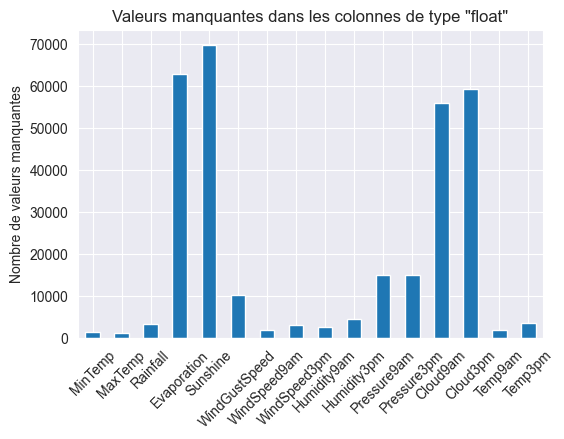

In [56]:
float_features = [column_name for column_name in dataset.columns if dataset[column_name].dtype != 'O']
missing_values_float = dataset[float_features].isnull().sum()

plt.figure(figsize=(6, 4))
missing_values_float.plot(kind='bar')
plt.ylabel('Nombre de valeurs manquantes')
plt.title('Valeurs manquantes dans les colonnes de type "float"')
plt.xticks(rotation=45)
plt.show()

Parmi les options possibles, nous avons décidé d'opter pour la méthode de l'imputation, qui consiste à remplacer les valeurs manquantes par une valeur estimée.
Cette décision a été motivée par le fait que le pourcentage de valeurs manquantes est relativement faible pour la plupart des colonnes, avec seulement quatre colonnes ayant des valeurs nulles inférieures à 50%.

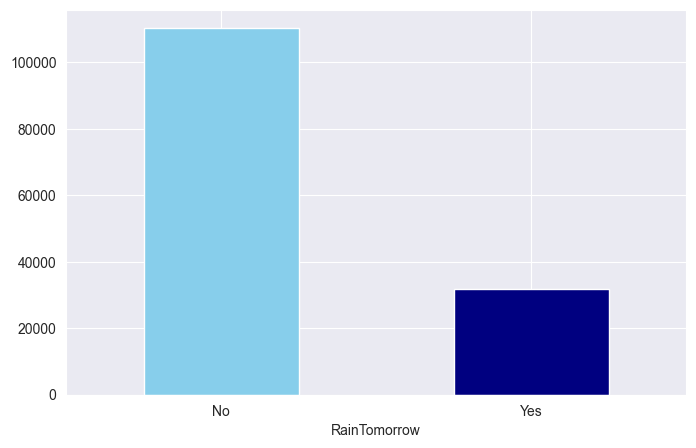

In [57]:
fig = plt.figure(figsize = (8,5))
dataset['RainTomorrow'].value_counts().plot(kind='bar', color= ['skyblue', 'navy'], rot=0)
plt.show()


Grâce au diagramme, nous pouvons observer un déséquilibre important entre les classes de notre variable cible "RainTomorrow". Le nombre d'échantillons de la classe "Yes" est nettement inférieur au nombre d'échantillons de la classe "No".
Ce déséquilibre peut entraîner des problèmes lors de l'entraînement de notre modèle, car il peut être biaisé en faveur de la classe majoritaire.

Afin de remédier à ce déséquilibre, nous allons utiliser la méthode du sur-échantillonnage de la classe minoritaire "Yes". Cette méthode consiste à créer de nouveaux échantillons en dupliquant aléatoirement les échantillons existants de la classe minoritaire jusqu'à atteindre un équilibre avec la classe majoritaire.

En appliquant cette technique, nous nous assurons que notre modèle dispose d'un nombre suffisant d'exemples positifs de pluie ("Yes") pour apprendre et généraliser correctement. Cela permettra d'améliorer la performance et la précision de notre modèle lors de la prédiction de la variable cible "RainTomorrow".

Avant de procéder au sur-échantillonnage, nous allons effectuer une copie de notre dataset afin de conserver les données d'origine intactes.

In [58]:
data = dataset.copy()
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


On effectue une transformation sur les variables "RainToday" et "RainTomorrow" en remplaçant les valeurs "Yes" par 1 et les valeurs "No" par 0.

In [59]:
data['RainToday'].replace({'No': 0, 'Yes': 1}, inplace=True)
data['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace=True)

data['RainTomorrow'].value_counts() / len(data)

RainTomorrow
0.0    0.758394
1.0    0.219146
Name: count, dtype: float64

### Sur-échantillonnage de la classe minoritaire "Yes". (Oversampling)

In [60]:
no = data[data.RainTomorrow == 0]
yes = data[data.RainTomorrow == 1]
oversampling_yes = resample(yes,replace = True,n_samples = len(no),random_state = 123)
oversampling = pd.concat([no,oversampling_yes])

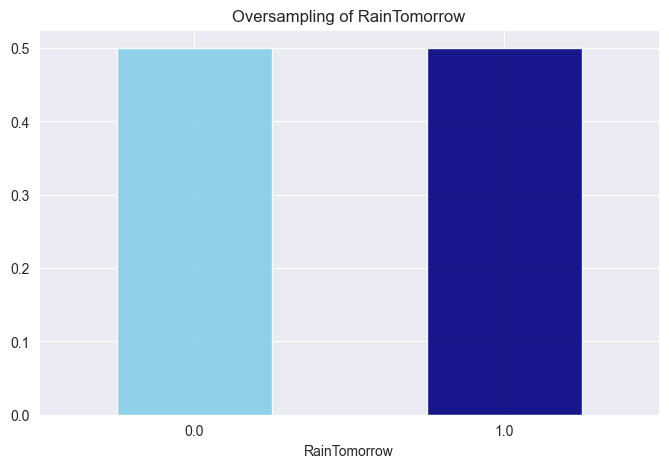

In [61]:
figure = plt.figure(figsize=(8,5))
oversampling.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'],alpha = 0.9,rot= 0)
plt.title("Oversampling of RainTomorrow")
plt.show()

### Traitement des valeurs manquantes
Pour traiter les valeurs manquantes dans notre ensemble de données, nous allons d’abord séparer les variables en deux groupes : les variables de type “object” et les variables de type “float”.
En ce qui concerne les variables de type “float”, nous devons prendre une décision sur la manière de traiter les valeurs manquantes. Selon la nature des données et l’ampleur des valeurs manquantes, nous pourrions envisager différentes approches telles que la suppression des lignes contenant des valeurs manquantes, l’imputation des valeurs manquantes.

In [62]:
#Les variables numériques
float_features = [column for column in oversampling.columns if oversampling[column].dtypes != 'O']
float_features

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday',
 'RainTomorrow']

In [63]:
#Les valeurs object
object_features = oversampling.select_dtypes(include=['object']).columns
object_features

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

Pour les variables de type "object", nous allons remplacer les valeurs manquantes par le mode, c'est-à-dire la valeur la plus fréquente dans chaque colonne. Cette approche est appropriée pour les variables catégorielles, car elle permet de conserver la distribution existante des valeurs et évite l'introduction de biais.

In [64]:
columns_to_fillNA = ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
for column in columns_to_fillNA:
    oversampling[column] = oversampling[column].fillna(oversampling[column].mode()[0])

In [65]:
oversampling[object_features].isnull().sum()

Date           0
Location       0
WindGustDir    0
WindDir9am     0
WindDir3pm     0
dtype: int64

## B.1 Nettoyage (data cleaning), Encodage (encoding) et train-test-validation split

On encode les variables catégorielles avec LabelEncoder : qui attribue une valeur numérique unique à chaque catégorie dans une colonne.
 Cela permet au modèle de traiter les variables catégorielles en tant que variables numériques.

L'usage de LabelEncoder dans notre cas est une approche raisonnable pour encoder les variables catégorielles, car il n'y a pas de notion d'ordre implicite dans les catégories.

In [66]:
encoding_dict = {}
for column in oversampling.select_dtypes(include=['object']).columns:
    encoding_dict[column] = LabelEncoder()
    oversampling[column] = encoding_dict[column].fit_transform(oversampling[column])

In [67]:
oversampling.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,396,2,13.4,22.9,0.6,NaN,NaN,13,44.0,13,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,0.0
1,397,2,7.4,25.1,0.0,NaN,NaN,14,44.0,6,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,0.0
2,398,2,12.9,25.7,0.0,NaN,NaN,15,46.0,13,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0.0,0.0
3,399,2,9.2,28.0,0.0,NaN,NaN,4,24.0,9,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0.0,0.0
4,400,2,17.5,32.3,1.0,NaN,NaN,13,41.0,1,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,0.0


Pour traiter les valeurs manquantes dans les variables de type float, nous avons choisi d'utiliser la méthode d'imputation MICE (Multiple Imputation by Chained Equations).
La méthode MICE est une approche statistique pour estimer les valeurs manquantes en se basant sur les relations entre les variables.

Contrairement à une simple imputation par la moyenne ou par une valeur fixe, la méthode MICE prend en compte les relations et les patterns présents dans les données. Elle fonctionne en plusieurs étapes, où chaque variable manquante est estimée en utilisant les autres variables disponibles dans le jeu de données.

L'avantage de la méthode MICE est qu'elle permet de préserver la structure et les relations entre les variables, ce qui peut conduire à des estimations plus précises des valeurs manquantes. Elle est particulièrement utile lorsque les données présentent une corrélation entre les variables ou lorsque les valeurs manquantes sont présentes de manière aléatoire.

##### Methode MICE

In [68]:
data_imputationMice = oversampling.copy(deep = True)
mice_input = IterativeImputer()
data_imputationMice.iloc[:, :] = mice_input.fit_transform(oversampling)

C:\Users\Emily\Rain_Australia\venv\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [69]:
data_imputationMice.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,396,2,13.4,22.9,0.6,5.734653,7.446035,13,44.0,13,...,71.0,22.0,1007.7,1007.1,8.000000,4.848545,16.9,21.8,0.0,0.0
1,397,2,7.4,25.1,0.0,5.639329,11.520531,14,44.0,6,...,44.0,25.0,1010.6,1007.8,1.731945,2.625892,17.2,24.3,0.0,0.0
2,398,2,12.9,25.7,0.0,7.762688,12.348852,15,46.0,13,...,38.0,30.0,1007.6,1008.7,1.827673,2.000000,21.0,23.2,0.0,0.0
3,399,2,9.2,28.0,0.0,5.977293,11.811634,4,24.0,9,...,45.0,16.0,1017.6,1012.8,1.233996,2.116194,18.1,26.5,0.0,0.0
4,400,2,17.5,32.3,1.0,6.852837,5.728406,13,41.0,1,...,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,0.0,0.0


In [70]:
data_imputationMice.isna().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

Une fois que nous avons géré le problème des valeurs manquantes, il est important de vérifier la présence de valeurs aberrantes afin de garantir la qualité des données utilisées pour l'apprentissage du modèle.

Pour détecter les valeurs aberrantes, nous allons calculer l'IQR (Interquartile Range), qui est une mesure statistique utilisée pour évaluer la dispersion des données. Les valeurs aberrantes sont généralement définies comme étant en dehors de l'intervalle interquartile.

En calculant l'IQR et en utilisant cette formule, vous pouvez identifier les valeurs qui sont considérées comme des outliers. Ces valeurs peuvent être ensuite visualisées à l'aide d'un graphique, qui met en évidence les valeurs extrêmes.

##### Interquartile Range

In [71]:
#IQR
q1 = data_imputationMice.quantile(0.25)
q3 = data_imputationMice.quantile(0.75)
iqr = q3 - q1
iqr

Date             1535.000000
Location           25.000000
MinTemp             9.300000
MaxTemp            10.200000
Rainfall            2.400000
Evaporation         4.120044
Sunshine            5.979485
WindGustDir         9.000000
WindGustSpeed      19.000000
WindDir9am          8.000000
WindDir3pm          8.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        30.000000
Pressure9am         8.800000
Pressure3pm         8.800000
Cloud9am            4.000000
Cloud3pm            3.684676
Temp9am             9.300000
Temp3pm             9.800000
RainToday           1.000000
RainTomorrow        1.000000
dtype: float64

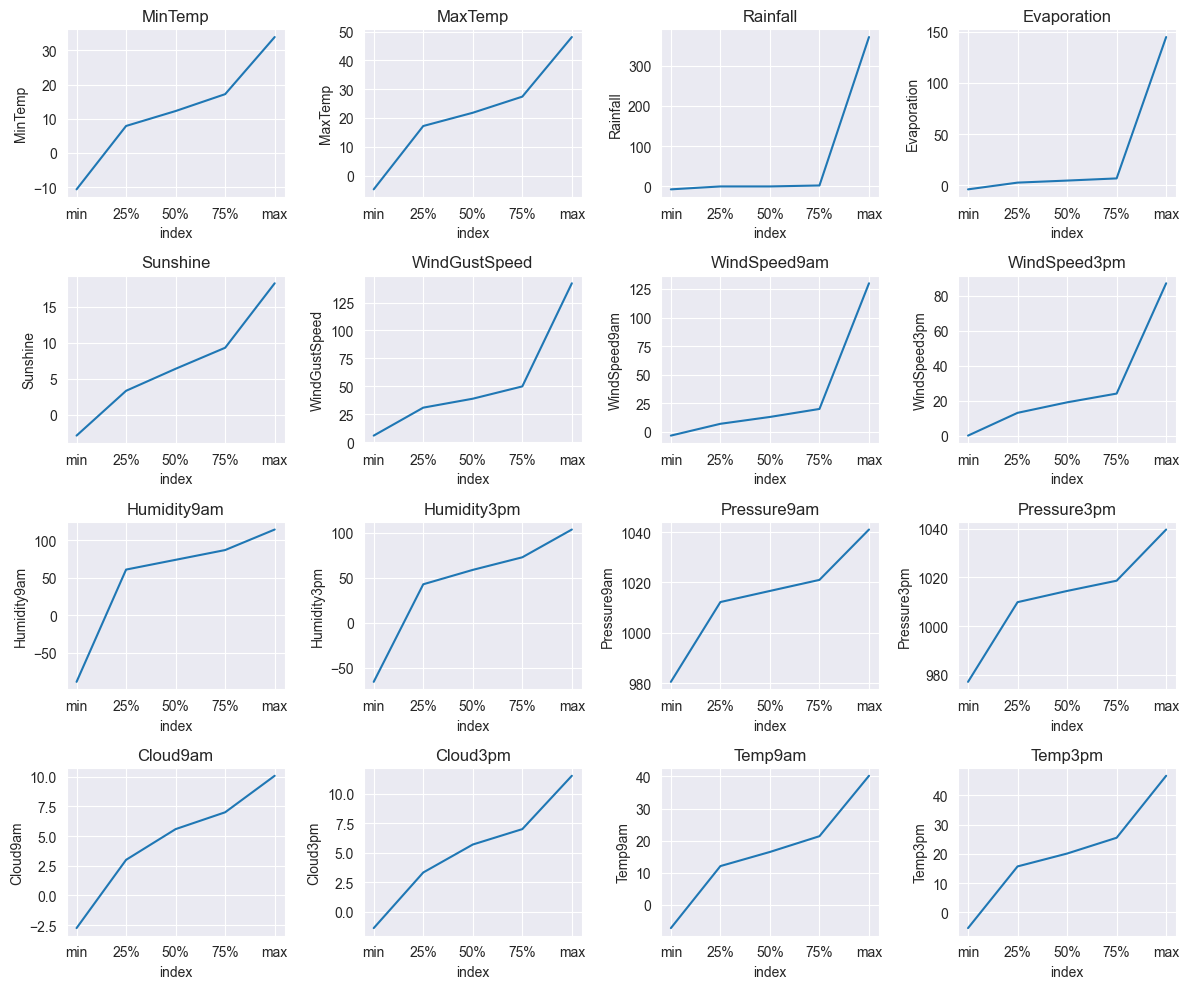

In [72]:
def plot_result(data_res):
    descr_float = data_res.describe(include=['int64','float64'])
    descr_float.reset_index(inplace=True)
    descr_float = descr_float[descr_float['index'] != 'count']
    descr_float = descr_float[~descr_float['index'].isin(['mean','std'])]

    figures, axes = plt.subplots(nrows = 4, ncols =4, figsize = (12,10))

    for i, ax in zip(descr_float.columns[1:], axes.flatten()):
        sns.lineplot(x='index', y=i, data = descr_float,ax = ax)
        ax.set_title(i)

    plt.tight_layout()
    plt.show()

plot_result(data_imputationMice)

Comme nous pouvons le voir sur les différents graphiques, certaines colonnes telles que MinTemp, MaxTemp, Rainfall, Evaporation, etc. présentent une distribution inégale des données ou des valeurs aberrantes. Cela suggère que la majorité des données se concentrent dans une plage spécifique, tandis qu'une minorité de données peuvent être éloignée de cette plage.

Il est crucial de prendre en compte ces observations lors de la construction du modèle, car si elles ne sont pas correctement gérées, elles peuvent fausser considérablement les résultats de prédiction.
Ainsi, il est recommandé de mettre en place des méthodes de prétraitement des données, telles que l'élimination des valeurs aberrantes ou l'utilisation de techniques de mise à l'échelle, afin de garantir que les caractéristiques du dataset sont appropriées pour l'entraînement du modèle.

Maintenant que nous avons identifié les valeurs aberrantes dans notre dataset, nous pouvons procéder à leur suppression. Cela permettra d'éliminer les données qui sont considérées comme des valeurs extrêmes et qui pourraient influencer négativement notre modèle.

In [73]:
data_imputationMice = data_imputationMice[~((data_imputationMice < (q1 - 1.5 * iqr)) | (data_imputationMice > (q3 + 1.5 * iqr))).any(axis = 1)]

Nous allons analyser la corrélation entre les variables de notre dataset, nous allons créer une heatmap.

Cependant, afin d'éviter la redondance et d'améliorer la lisibilité, nous allons masquer la moitié de la heatmap qui est symétrique par rapport à la diagonale principale.

Cela nous permettra d'identifier les relations linéaires entre les variables et de déterminer lesquelles sont fortement corrélées, ce qui peut être utile lors de la sélection des caractéristiques pour notre modèle de prédiction.

<Axes: >

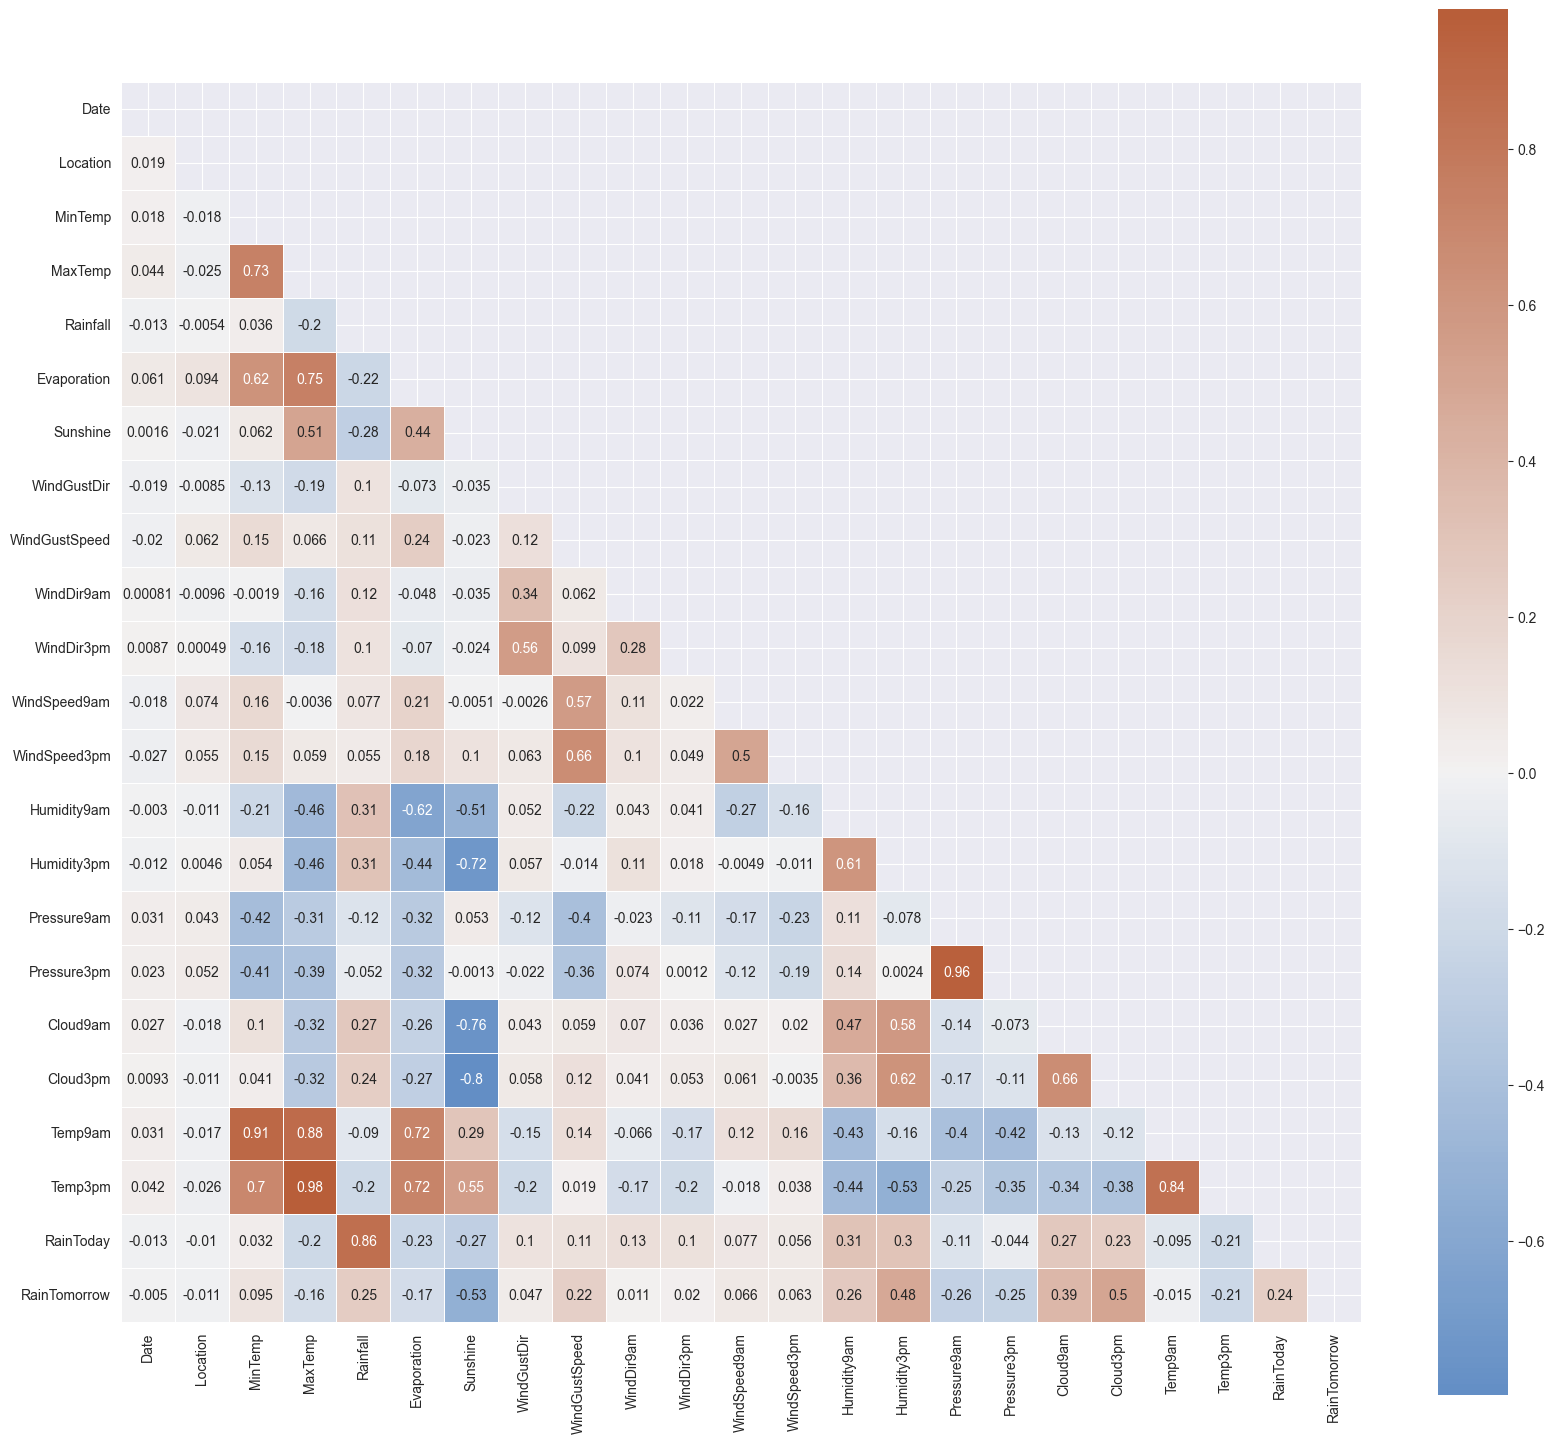

In [74]:
corr = data_imputationMice.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, s=75,l=50, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

Lors de l'observation de la heatmap, nous remarquons qu'il existe quelques variables qui présentent une corrélation significative entre elles. Par exemple, nous pouvons voir une corrélation positive entre les variables MaxTemp et MinTemp, ce qui est logique, car elles sont toutes deux liées à la température. De même, nous observons une corrélation entre les variables Pressure9am et Pressure3pm, ainsi qu'entre Temp9am et Temp3pm.

Cependant, il est important de noter qu'aucune paire de caractéristiques ne présente une corrélation parfaite (égale à 1). Cela signifie que toutes les caractéristiques de notre analyse apportent des informations uniques et ne peuvent pas être complètement exclues.

Cette observation confirme l'importance de prendre en compte toutes les caractéristiques lors de la construction de notre modèle de prédiction, car chacune d'entre elles contribue à sa manière à la prédiction de la variable cible RainTomorrow.

##### PREPROCESSING
Maintenant, nous allons préparer nos données.

Nous allons effectuer une mise à l'échelle des données à l'aide du MinMaxScaler. La mise à l'échelle consiste à transformer les valeurs de nos variables de sorte qu'elles soient toutes comprises dans une plage spécifiée, généralement entre 0 et 1.

In [75]:
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(data_imputationMice)
new_data = pd.DataFrame(r_scaler.transform(data_imputationMice), index=data_imputationMice.index, columns=data_imputationMice.columns)
new_data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,0.115284,0.041667,0.543417,0.514778,0.437385,0.569756,0.512042,0.866667,0.521127,0.866667,...,0.551807,0.222773,0.245714,0.298295,0.868449,0.420458,0.506775,0.530612,0.24783,0.0
1,0.115575,0.041667,0.375350,0.568966,0.374872,0.563868,0.745836,0.933333,0.521127,0.400000,...,0.247750,0.252666,0.328571,0.318182,0.339380,0.227713,0.514905,0.594388,0.24783,0.0
2,0.115866,0.041667,0.529412,0.583744,0.374872,0.695026,0.793365,1.000000,0.549296,0.866667,...,0.180182,0.302488,0.242857,0.343750,0.347461,0.173437,0.617886,0.566327,0.24783,0.0
3,0.116157,0.041667,0.425770,0.640394,0.374872,0.584743,0.762539,0.266667,0.239437,0.600000,...,0.259012,0.162986,0.528571,0.460227,0.297350,0.183513,0.539295,0.650510,0.24783,0.0
4,0.116448,0.041667,0.658263,0.746305,0.479060,0.638825,0.413485,0.866667,0.478873,0.066667,...,0.675683,0.332382,0.334286,0.267045,0.784042,0.693747,0.531165,0.732143,0.24783,0.0


Après avoir effectué la mise à l'échelle des données, nous pouvons maintenant appliquer la méthode du chi-carré pour sélectionner les meilleures variables prédictives.

La méthode du chi-carré est une technique de sélection de variables basée sur le test du même nom. Elle évalue la relation entre chaque variable indépendante (ou caractéristique) et la variable cible (ici, RainTomorrow) en utilisant des tableaux de contingence et le test du chi-carré.

In [76]:
from sklearn.feature_selection import SelectKBest, chi2
X = new_data.loc[:,new_data.columns!='RainTomorrow']
y = new_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=15)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp3pm',
       'RainToday'],
      dtype='object')


### Train test split
Maintenant, nous allons diviser notre jeu de données en ensembles d'entraînement (train) et de test (test) à l'aide de la méthode Train-Test-Split. Cette méthode va nous permettre de le faire simplement en spécifiant les données, notre variable cible 'RainTomorrow', la taille du jeu de tests et une valeur aléatoire pour rendre le split reproductible.

In [77]:
#features = data_imputationMice.drop(colums=['Date', 'Location', 'WinDir9am', 'WinDir3pm', 'WindSpeed9am', 'WindSpeed3pm', ''])

In [78]:
features = data_imputationMice

In [79]:
features = data_imputationMice.drop(columns=['Date', 'Location', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Temp9am', 'Temp3pm'])

target = data_imputationMice['RainTomorrow']
features = features.drop(['RainTomorrow'], axis=1)


In [80]:
from sklearn.model_selection import train_test_split

In [81]:
test_ratio = 0.25
seed = 20

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_ratio, random_state=seed)

##### Fonction ROC
Receiver Operating Characteristic, est un graph qui montre les performances d'un modèle de classification : plus la courbe s'approche du coin supérieur gauche, plus le modèle approche la classification parfaite

In [88]:
def curve(false_positive, true_positive):
    plt.plot(false_positive, true_positive, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [89]:
from sklearn.metrics import accuracy_score, confusion_matrix,roc_auc_score, roc_curve, classification_report

In [97]:
def print_mod(model, X_train, y_train, X_test, y_test):

    model.fit(X_train,y_train)

    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    train_accuracy = accuracy_score(y_train,model.predict(X_train))

    print("Test Accuracy =  {:.2f}%".format(test_accuracy))
    print("Train Accuracy =  {:.2f}%".format(train_accuracy))

    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    false_positive, true_positive, thresholds = roc_curve(y_test, probs)
    curve(false_positive, true_positive)

    return model, test_accuracy

In [98]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]*100
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

### Modèle: Random Forest.

Test Accuracy =  0.92%
Train Accuracy =  0.96%


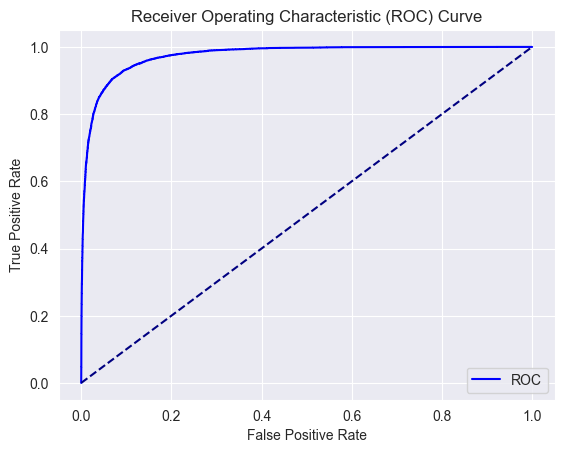

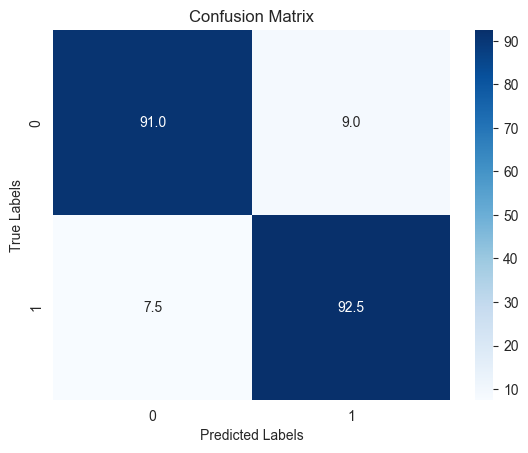

In [115]:
from sklearn.ensemble import RandomForestClassifier

hyper_parameters_rf = {'max_depth': 15,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 95,
             'random_state': 20}

random_forest = RandomForestClassifier(**hyper_parameters_rf)
random_forest, tt_rf = print_mod(random_forest, X_train, y_train, X_test, y_test)
y_pred_randomforest = random_forest.predict(X_test)
plot_confusion_matrix(y_test, y_pred_randomforest)

Test Accuracy =  0.89%
Train Accuracy =  0.94%


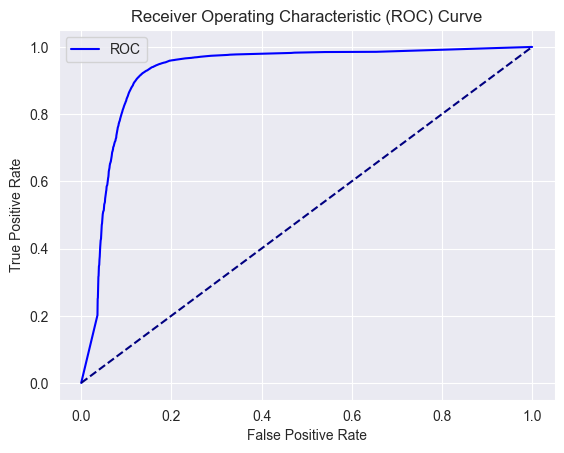

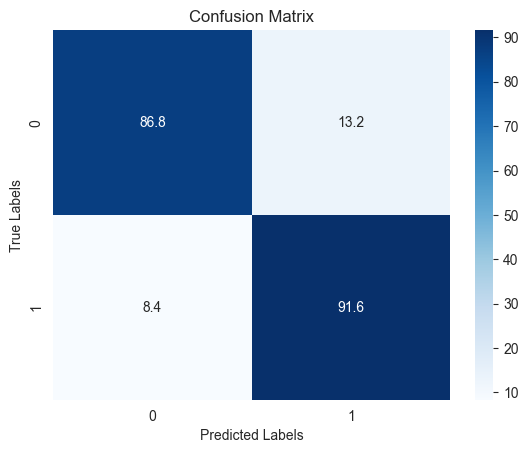

In [118]:
from sklearn.tree import DecisionTreeClassifier

hyper_parameters_dtc = {
    'max_depth': 15,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'random_state': 20
}

decision_tree = DecisionTreeClassifier(**hyper_parameters_dtc)
decision_tree, tt_decision = print_mod(decision_tree, X_train, y_train, X_test, y_test)

y_pred_decisiontree = decision_tree.predict(X_test)
plot_confusion_matrix(y_test, y_pred_decisiontree)

Test Accuracy =  0.76%
Train Accuracy =  0.76%


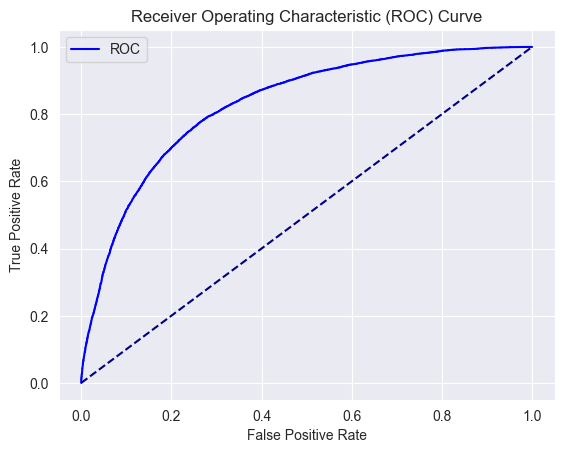

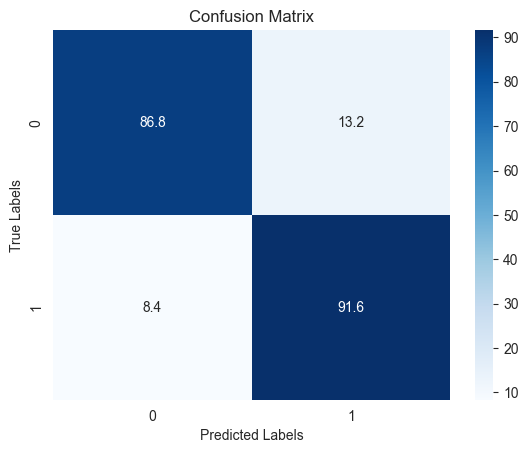

In [123]:
from sklearn.naive_bayes import GaussianNB

NB = GaussianNB()
NB, tt_KN = print_mod(NB, X_train, y_train, X_test, y_test)

y_pred_NB = decision_tree.predict(X_test)
plot_confusion_matrix(y_test, y_pred_NB)

ANALYSE DES RESULTATS
Le modèle RandomForest présente une performance globalement satisfaisante. L'exactitude est élevée, ce qui indique une bonne capacité à classifier les exemples dans les deux classes. L'AUC-ROC est également assez élevée, ce qui suggère une bonne capacité à distinguer entre les classes. Cependant, il est important de noter que la précision et le rappel varient légèrement entre les deux classes, avec une légère baisse de la précision pour la classe 1 (RainTomorrow : Yes).

In [125]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold, cross_val_score

In [126]:
def plot_cross_validation(n_split, model):

    k_folds = KFold(n_splits = n_split)
    scores = cross_val_score(model, X_train, y_train, cv = k_folds)
    print("Split size: ", X_train.shape[0]/n_split)
    print("Cross Validation Scores:\n",scores)
    print("Average CV Score: ", scores.mean())
    return scores.mean()
models = []

In [127]:
CV_GaussianNB = plot_cross_validation(5, GaussianNB())
models.append(('GaussianNBClassifier', CV_GaussianNB))

Split size:  25600.2
Cross Validation Scores:
 [0.75590797 0.75425781 0.75722656 0.75589844 0.75632813]
Average CV Score:  0.755923781968966


In [128]:
params_dt = {'max_depth': 15,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'random_state': 20}

CV_DecisionTree = plot_cross_validation(5, DecisionTreeClassifier(**params_dt))
models.append(('DecisionTreeClassifier', CV_DecisionTree))

Split size:  25600.2
Cross Validation Scores:
 [0.88105933 0.87683594 0.87761719 0.87890625 0.88605469]
Average CV Score:  0.8800946792239561


In [129]:
params_rf = {'max_depth': 15,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 95,
             'random_state': 20}

CV_RandomForest = plot_cross_validation(5, RandomForestClassifier(**params_rf))
models.append(('RandomForestClassifier', CV_RandomForest))

Split size:  25600.2
Cross Validation Scores:
 [0.91246436 0.91382812 0.90929688 0.91207031 0.91015625]
Average CV Score:  0.911563183872212


In [130]:
array = pd.DataFrame(models)
st = array.sort_values(by=1)
st

,0,1
0,GaussianNBClassifier,0.755924
1,DecisionTreeClassifier,0.880095
2,RandomForestClassifier,0.911563
